In [2]:
import netCDF4
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import matplotlib


import matplotlib.tri as tri
from matplotlib.colors import ListedColormap
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import imageio
#from sklearn.mixture import GaussianMixture
#from clustering_concentration import *
def quatplot(y, z, quadrangles, values, ax=None, **kwargs):
    if not ax: ax = plt.gca()
    yz = np.c_[y,z]
    verts = yz[quadrangles]
    pc = matplotlib.collections.PolyCollection(verts, **kwargs)
    pc.set_array(values)
    ax.add_collection(pc)
    ax.autoscale()
    return pc



def showEltPlot(nodes, elements, values, titlelabel=[""], size=[5, 5], ax=None, p_ext=[0.2, 0.2],
                colormap='viridis', e_notation=False, assign_bar_range=[], 
                x_unit=r'x (m)', y_unit=r'y (m)',font_adjust=1.8):

    y = nodes[:, 0]
    z = nodes[:, 1]
    size_factor=np.array(size).mean()*font_adjust
    if ax is None:
        fig, ax = plt.subplots(dpi=144, figsize=(size[0], size[1]))
    else:
        fig = ax.figure
    ax.set_aspect('equal')

    # 設定色階範圍
    if assign_bar_range:
        vmin, vmax = assign_bar_range
    else:
        vmin, vmax = values.min(), values.max()

    # 畫主圖
    pc = quatplot(y, z, np.asarray(elements), values, ax=ax,
                  edgecolor='face', cmap=colormap)
    pc.set_clim(vmin, vmax)
    # 軸範圍設定
    x_min, x_max = y.min(), y.max()
    y_min, y_max = z.min(), z.max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    ax.set_xlim(x_min - x_range * p_ext[0], x_max + x_range * p_ext[0])
    ax.set_ylim(y_min - y_range * p_ext[1], y_max + y_range * p_ext[1])


    # 加 colorbar（這之後才能設定 ticks）
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    cbar = fig.colorbar(pc, cax=cax, fraction=0.046, pad=0.04)

    # 設定 ticks
    ticks = np.linspace(vmin, vmax, 6)
    cbar.set_ticks(ticks)
    if e_notation:
        cbar.set_ticklabels([f"{tick:.2e}" for tick in ticks],fontsize=size_factor)
    else:
        cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks],fontsize=size_factor)
    cbar.set_label(titlelabel[-1], rotation=270, labelpad=15)

    # 標題與軸標籤
    
    ax.set_title(titlelabel[0],fontsize=1.5*size_factor)
    ax.set_xlabel(x_unit,fontsize=size_factor)
    ax.set_ylabel(y_unit,fontsize=size_factor)
    ax.tick_params(axis='x', labelsize=size_factor)
    ax.tick_params(axis='y', labelsize=size_factor)
    return fig, ax, cbar



def showNodePlot(nodes, elements, nodal_values, titlelabel=[""], size=[5, 5], ax=None, p_ext=[0.2, 0.2], 
                 colormap='viridis', e_notation=False, assign_bar_range=[]
                 , x_unit=r'x (m)', y_unit=r'y (m)',font_adjust=1.8,levels_num=200):
    y = nodes[:, 0]
    z = nodes[:, 1]
    size_factor=np.array(size).mean()*font_adjust
    if ax is None:
        fig, ax = plt.subplots(dpi=144, figsize=(size[0], size[1]))
    else:
        fig = ax.figure
    ax.set_aspect('equal')

    def quads_to_tris(quads):
        tris = []
        for n0, n1, n2, n3 in quads:
            tris.append([n0, n1, n2])
            tris.append([n2, n3, n0])
        return tris

    elements_all_tris = quads_to_tris(elements)
    triangulation = tri.Triangulation(y, z, elements_all_tris)

    # 設定色階範圍
    if assign_bar_range:
        vmin, vmax = assign_bar_range
    else:
        vmin, vmax = nodal_values.min(), nodal_values.max()
    vmin, vmax= vmin* 0.99999, vmax* 1.00001
    levels = np.linspace(vmin, vmax, levels_num)
    #print([vmin, vmax])
    pc = ax.tricontourf(triangulation, nodal_values, levels=levels, cmap=colormap, vmin=vmin, vmax=vmax)
    # 加 colorbar（在這之後才能設 tick）
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    cbar = fig.colorbar(pc, cax=cax)
    # 軸範圍
    x_min, x_max = y.min(), y.max()
    y_min, y_max = z.min(), z.max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    ax.set_xlim(x_min - x_range * p_ext[0], x_max + x_range * p_ext[0])
    ax.set_ylim(y_min - y_range * p_ext[1], y_max + y_range * p_ext[1])


    # 設 ticks（這裡使用 vmin/vmax 生成）
    ticks = np.linspace(vmin, vmax, 6)
    cbar.set_ticks(ticks)
    if e_notation:
        cbar.set_ticklabels([f"{tick:.2e}" for tick in ticks],fontsize=size_factor)
    else:
        cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks],fontsize=size_factor)
    cbar.set_label(titlelabel[-1], rotation=270, labelpad=15)
    # 標題與軸標籤
    ax.set_title(titlelabel[0],fontsize=1.5*size_factor)
    ax.set_xlabel(x_unit,fontsize=size_factor)
    ax.set_ylabel(y_unit,fontsize=size_factor)
    ax.tick_params(axis='x', labelsize=size_factor)
    ax.tick_params(axis='y', labelsize=size_factor)

    return fig, ax, cbar




def read_vars(e_name, node_variable_idx, element_variable_idx):
    nc = netCDF4.Dataset(e_name)
    var_keys=list(nc.variables.keys())
    print(var_keys)
    #Load coordinates
    coord_str=[k for k in var_keys if "coord" in k]
    coords=[np.array(nc.variables[k]) for k in coord_str]
    nodes=np.stack(coords).T
    times=np.array(nc.variables['time_whole'])
    #Deal with connectivity
    all_connect_str=[k for k in var_keys if "connect" in k]
    connect_components=[np.array(nc.variables[k])-1 for k in all_connect_str]
    global_connection=np.vstack([cp for cp in connect_components])

    #Extract element_quantities
    elet_block_num=len(all_connect_str)
    element_blocks_var_keys=[]
    for ebid in range(elet_block_num):
        element_blocks_var_keys.append(["vals_elem_var"+str(idx)+"eb"+str(ebid+1) for idx in element_variable_idx])
    element_blocks_var_quantities=[]
    for ebid in range(elet_block_num):
        element_blocks_var_quantities.append([np.array(nc.variables[k]) for k in element_blocks_var_keys[ebid]])
    elet_vars=[]
    for var_idx in range(len(element_variable_idx)):
        quant=np.array([])
        for ebid in range(elet_block_num):
            data= element_blocks_var_quantities[ebid][var_idx]
            quant=np.hstack([quant,data ]) if quant.size else data
        elet_vars.append(quant)

    #Extract nodal variables
    nodal_var_keys=["vals_nod_var"+str(idx) for idx in node_variable_idx]
    node_vars=[np.array(nc.variables[k]) for k in nodal_var_keys]
    return nodes, connect_components, global_connection, node_vars, elet_vars,times

# I. Load data from .e

In [5]:
output_list=['simulation_files/No1_0p95_initd.e','simulation_files/No2_0p98_initd.e',
             'simulation_files2/No1_inidR0p05_2.e','simulation_files2/No2_inidR0p02_2.e']
models=[r"ELL1R005",r"ELL1R002",r"ELL2R005",r"ELL2R002"]

node_variable_idx=[1, 2 ,3 ,4]
node_var_labels=[[r"Temperature $\theta\;(^{\circ}C)$", ""],
                 [r"Phase Field Fracture Damage", ""],
                 [r"Displacement $u_x$ (m)", ""],
                 [r"Displacement $u_y$ (m)", ""]]

element_variable_idx=[3,]#12]
elt_var_labels=[[r"Energy Release Rate $G_c(x,y)$ MPa $\cdot$m", ""],
                ]


In [6]:
profiles = [read_vars(e_name, node_variable_idx, element_variable_idx) for e_name in output_list]


['time_whole', 'eb_status', 'eb_prop1', 'ns_status', 'ns_prop1', 'ss_status', 'ss_prop1', 'coordx', 'coordy', 'eb_names', 'ns_names', 'ss_names', 'coor_names', 'node_num_map', 'connect1', 'connect2', 'elem_num_map', 'elem_ss1', 'side_ss1', 'elem_ss2', 'side_ss2', 'elem_ss3', 'side_ss3', 'elem_ss4', 'side_ss4', 'elem_ss5', 'side_ss5', 'node_ns1', 'node_ns2', 'node_ns3', 'node_ns4', 'node_ns5', 'node_ns6', 'name_nod_var', 'vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'name_elem_var', 'vals_elem_var1eb1', 'vals_elem_var2eb1', 'vals_elem_var3eb1', 'vals_elem_var4eb1', 'vals_elem_var5eb1', 'vals_elem_var6eb1', 'vals_elem_var7eb1', 'vals_elem_var8eb1', 'vals_elem_var9eb1', 'vals_elem_var10eb1', 'vals_elem_var11eb1', 'vals_elem_var12eb1', 'vals_elem_var13eb1', 'vals_elem_var14eb1', 'vals_elem_var15eb1', 'vals_elem_var16eb1', 'vals_elem_var17eb1', 'vals_elem_var18eb1', 'vals_elem_var19eb1', 'vals_elem_var20eb1', 'vals_elem_var21eb1', 'vals_elem_var22eb1', 'vals_elem_var23

# Multiple plots in one plot

In [21]:
import pandas as pd

In [ ]:

for model_index in range(4):
    nodes, connect_components, global_connection, node_vars, elet_vars,times=profiles[model_index]
    node_df=pd.DataFrame(nodes)
    node_df.columns=['x(m)','y(m)']
    node_df.to_csv(models[model_index]+"_nodes.csv")

    damage_df = pd.DataFrame(node_vars[1].T)
    damage_df.columns = ["time = " + str(round(t,4)) + " (20 mins)" for t in times]
    damage_df.to_csv(models[model_index]+"_damages.csv")

: 

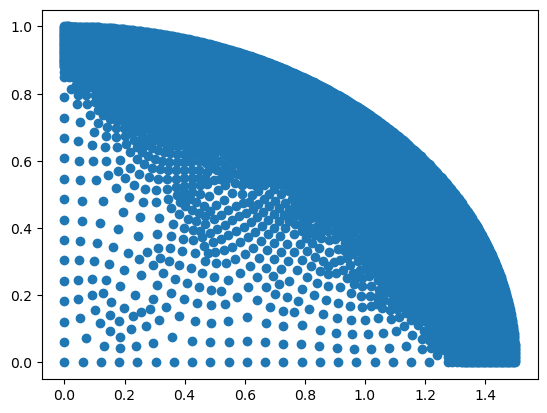

In [33]:
plt.scatter(nodes[:,0],nodes[:,1])

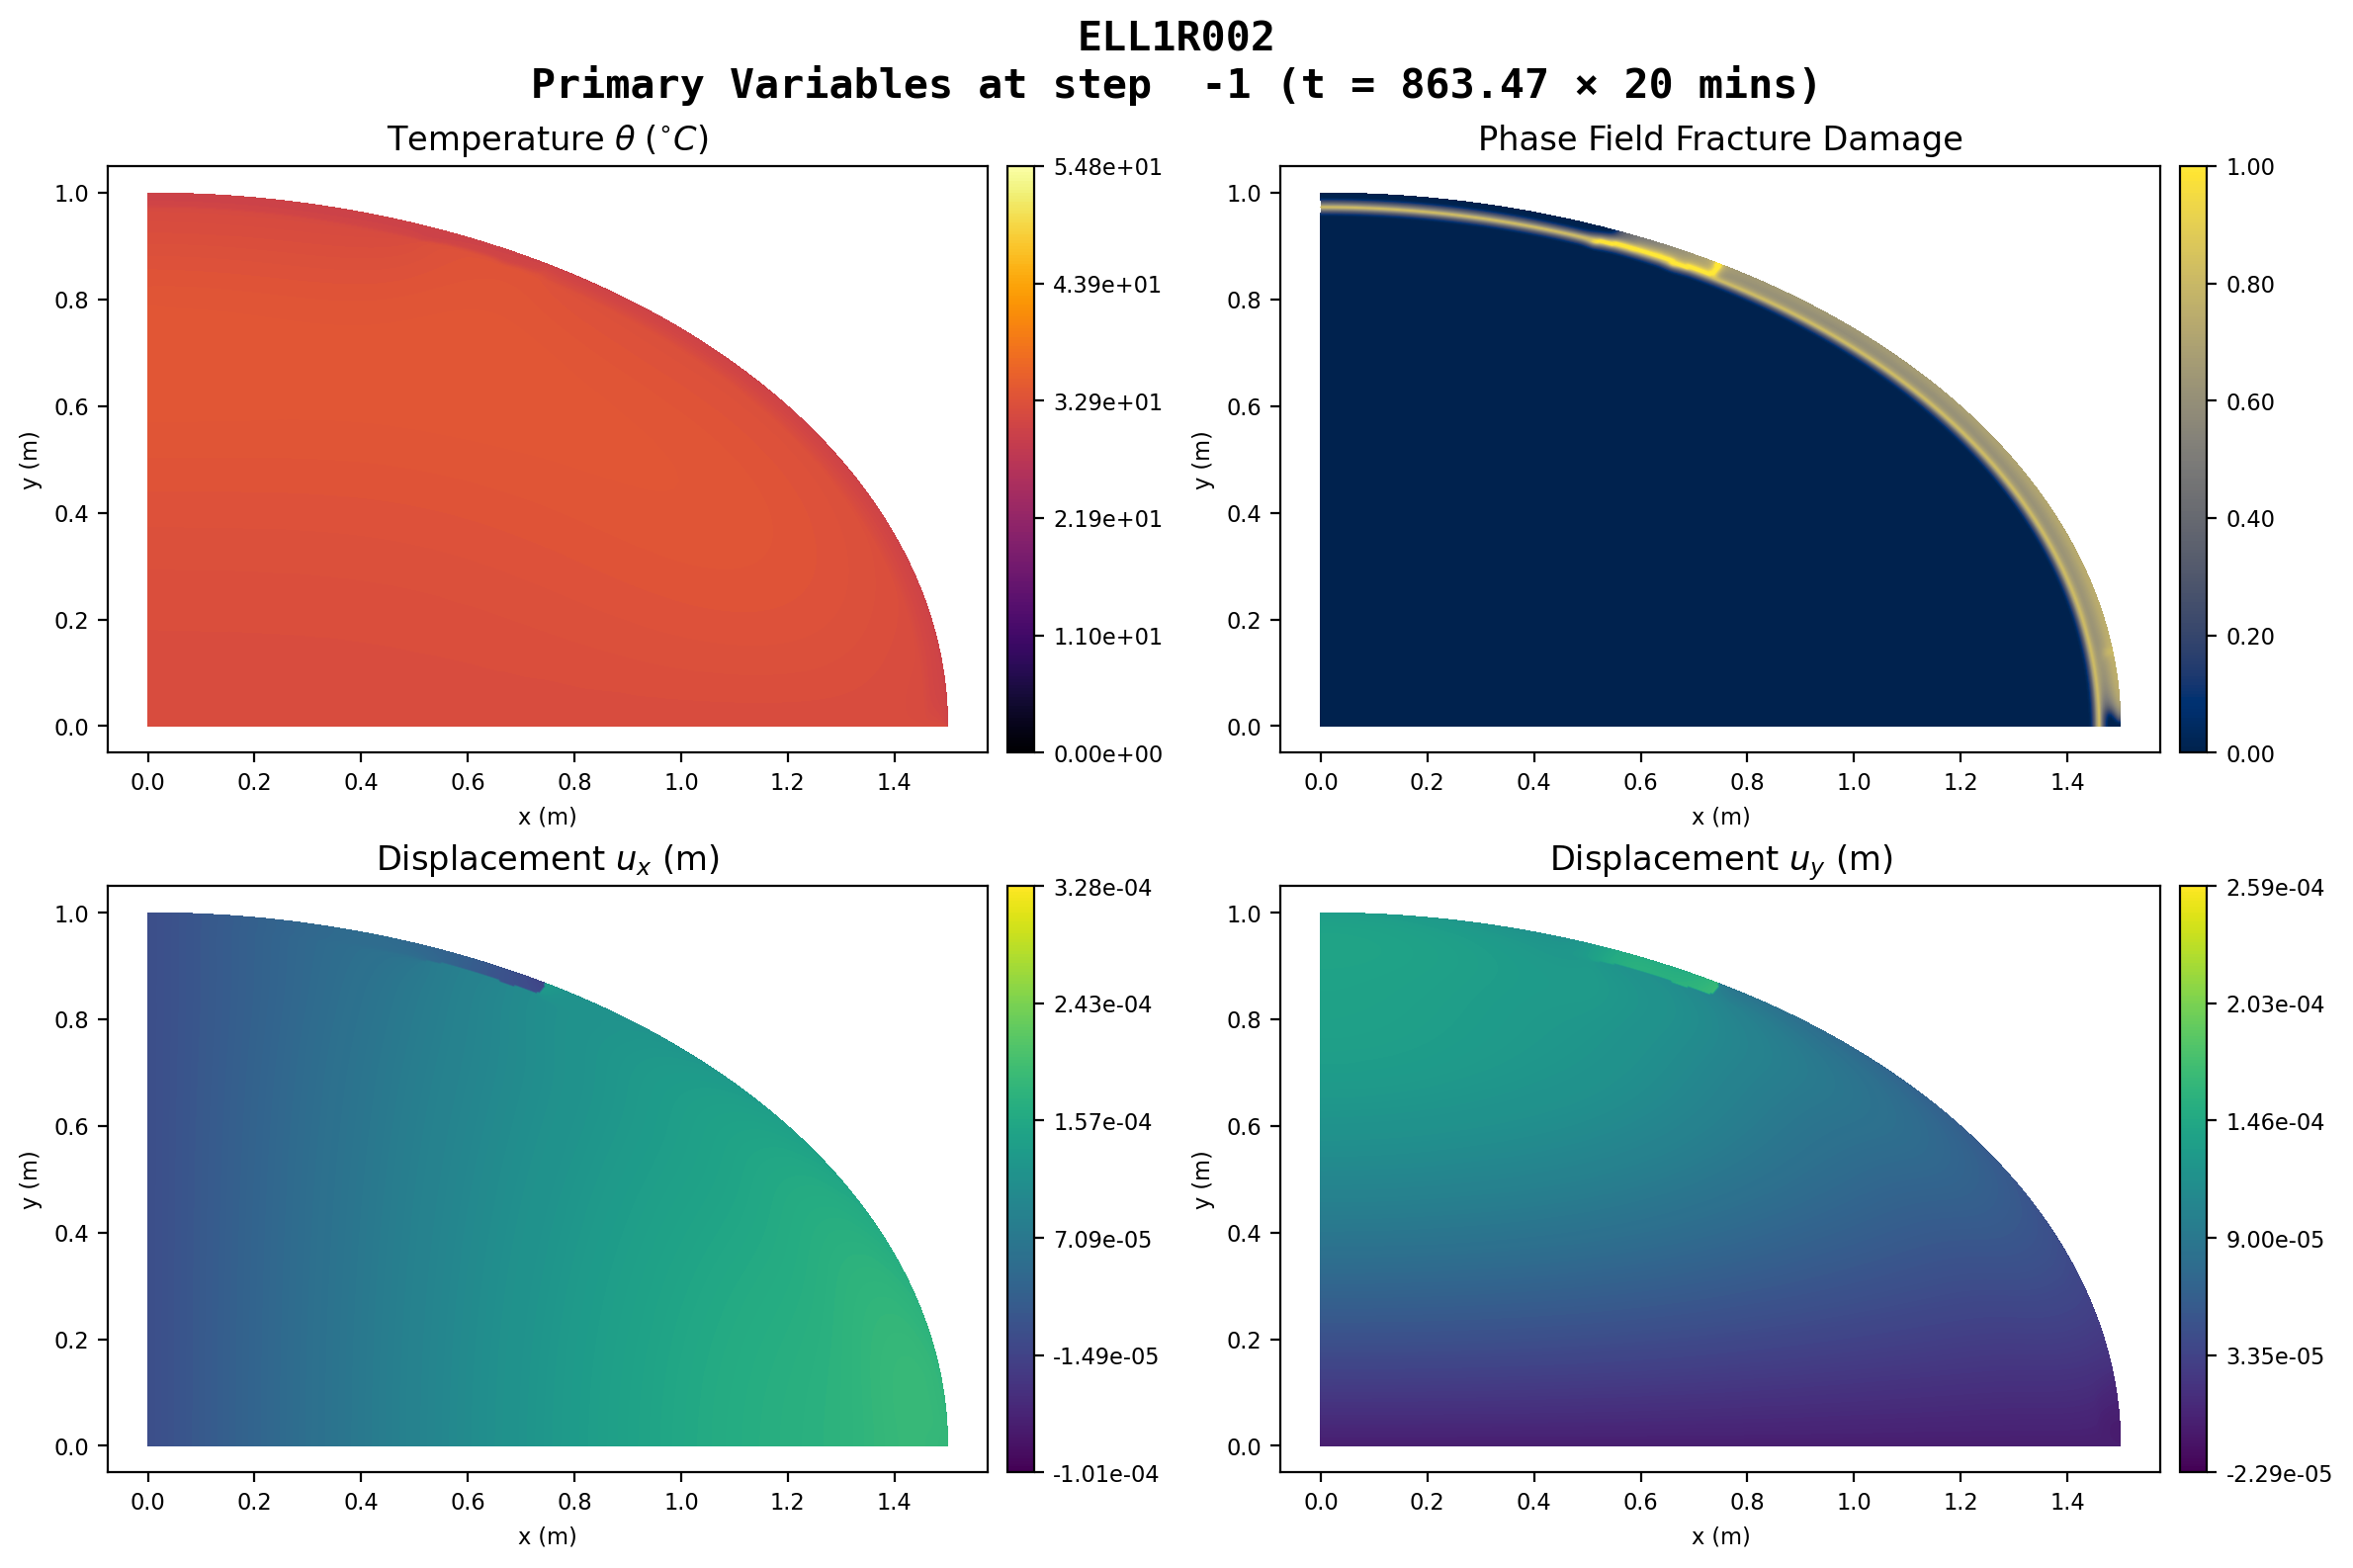

In [11]:
nr, nc = 2, 2  # 子圖數量設定
n_vars = len(node_vars)
step = -1  # 固定時間點
param_idx_list = range(n_vars)  # 要畫哪些變數（你也可以自訂 list）
color_maps=['inferno','cividis','viridis','viridis']
e_notations=[True,False,True,True]

fig, axes = plt.subplots(nr, nc, figsize=(nc * 6, nr * 4), dpi=200)
if nr * nc == 1:
    axes = [axes]
else:
    axes = axes.flatten()

fig.suptitle(
    f"{models[model_index]}\nPrimary Variables at step {step:3d} (t = {times[step]:06.2f} × 20 mins)",
    fontsize=15, fontweight="bold", fontname="DejaVu Sans Mono"
)


for i, idx in enumerate(param_idx_list):
    vmin = node_vars[param_idx_list[i]].min()
    vmax = node_vars[param_idx_list[i]].max()
    var = node_vars[idx][step]
    showNodePlot(
        nodes, global_connection, var,
        titlelabel=[node_var_labels[idx][0], node_var_labels[idx][1]],
        size=[6, 6], ax = axes[i], p_ext=[0.05, 0.05],
        colormap=color_maps[i], e_notation=e_notations[i],
        assign_bar_range=[vmin, vmax],
        x_unit=r'x (m)', y_unit=r'y (m)',
        font_adjust=1.35
    )

plt.tight_layout()
plt.subplots_adjust(top=0.89)  # 留空間給 suptitle
plt.show()


In [5]:
# Gif 
frames = []
temp_filenames = []

nr, nc = 2, 2  # 子圖數量設定
n_vars = len(node_vars)
param_idx_list = range(n_vars)  # 要畫哪些變數（你也可以自訂 list）
color_maps=['inferno','cividis','viridis','viridis']
e_notations=[True,False,True,True]


# start for loop step = 0
for step in range(len(times)):

    fig, axes = plt.subplots(nr, nc, figsize=(nc * 6, nr * 4), dpi=200)
    if nr * nc == 1:
        axes = [axes]
    else:
        axes = axes.flatten()


    #fig.suptitle(
    #    f"Primary Variables at step {step:2d} " + f"(t = {times[step]:06.4f} mm)",
    #    fontsize=25, fontweight="bold", fontname="DejaVu Sans Mono"
    #)
    fig.suptitle(
        f"{models[model_index]}\nPrimary Variables at step {step:3d} (t = {times[step]:06.2f} × 20 mins)",
        fontsize=15, fontweight="bold", fontname="DejaVu Sans Mono"
    )
    for i, idx in enumerate(param_idx_list):
        vmin = node_vars[param_idx_list[i]].min()
        vmax = node_vars[param_idx_list[i]].max()
        var = node_vars[idx][step]
        showNodePlot(
            nodes, global_connection, var,
            titlelabel=[node_var_labels[idx][0], node_var_labels[idx][1]],
            size=[6, 6], ax = axes[i], p_ext=[0.05, 0.05],
            colormap=color_maps[i], e_notation=e_notations[i],
            assign_bar_range=[vmin, vmax],
            x_unit=r'x (m)', y_unit=r'y (m)',
            font_adjust=1.35
        )

    plt.tight_layout()
    plt.subplots_adjust(top=0.89)  # 留空間給 suptitle
    #plt save
    #plt close figure
    # store frame for gif
    filename = f"frame_{step:03d}.png"
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)  # 重要：避免 memory overflow
    frames.append(imageio.imread(filename))  # imageio 已在外部定義
    temp_filenames.append(filename)  # 方便最後清理


C:\Users\aasam\AppData\Local\Temp\ipykernel_57576\3508387705.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))  # imageio 已在外部定義
C:\Users\aasam\AppData\Local\Temp\ipykernel_57576\3508387705.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))  # imageio 已在外部定義
C:\Users\aasam\AppData\Local\Temp\ipykernel_57576\3508387705.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) us

In [6]:
# **生成 GIF**
default_duration = 120
lag = 1500
duration = [default_duration] * (len(frames) - 1) + [lag]
reduced_frames=frames[::2]+[frames[-1]]
#reduced_frames=frames
reduced_frames=reduced_frames[::2]+[reduced_frames[-1]]
duration = [default_duration] * (len(reduced_frames) - 1) + [lag]
try:
    imageio.mimsave(models[model_index].split(':')[0]+'.gif', reduced_frames, loop=0, duration=duration)
except:
    imageio.mimsave(models[model_index]+'.gif', reduced_frames, loop=0, duration=duration)

In [7]:
import os
# **清除臨時文件**
for temp_file in temp_filenames:
    os.remove(temp_file)